In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os



2025-07-19 15:31:47.547178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752939107.792927      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752939107.858109      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# --- 1. Define Dataset Paths ---
# Adjust this path if your dataset is located elsewhere
# Assuming 'face-expression-recognition-dataset' is directly under /kaggle/input/
dataset_path = '/kaggle/input/face-expression-recognition-dataset/images'
train_dir = os.path.join(dataset_path, 'train')
validation_dir = os.path.join(dataset_path, 'validation')



In [3]:
# --- 2. Set Image Parameters ---
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 10 # You might need more epochs for better performance



In [4]:
# --- 3. Data Augmentation and Preprocessing ---
print("Setting up data generators...")
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1]
    rotation_range=20,          # Randomly rotate images
    width_shift_range=0.2,      # Randomly shift images horizontally
    height_shift_range=0.2,     # Randomly shift images vertically
    shear_range=0.2,            # Apply shearing transformations
    zoom_range=0.2,             # Randomly zoom into images
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill newly created pixels
)

validation_datagen = ImageDataGenerator(rescale=1./255) # Only rescale for validation

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

num_classes = train_generator.num_classes
class_names = list(train_generator.class_indices.keys())
print(f"Number of classes detected: {num_classes}")
print(f"Class names: {class_names}")



Setting up data generators...
Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Number of classes detected: 7
Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [5]:
# --- 4. Load Pre-trained Model (MobileNetV2 for Transfer Learning) ---
print("\nLoading MobileNetV2 base model...")
base_model = MobileNetV2(
    weights='imagenet',         # Use weights pre-trained on ImageNet
    include_top=False,          # Exclude the top classification layer
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3) # Input shape for RGB images
)

# Freeze the layers of the base model to prevent them from being updated during initial training
for layer in base_model.layers:
    layer.trainable = False




Loading MobileNetV2 base model...


I0000 00:00:1752939134.703277      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
# --- 5. Build Custom Classification Head ---
x = base_model.output
x = GlobalAveragePooling2D()(x) # Convert feature maps to a single vector
x = Dense(128, activation='relu')(x) # Add a new dense layer with ReLU activation
predictions = Dense(num_classes, activation='softmax')(x) # Output layer with softmax for multi-class classification

model = Model(inputs=base_model.input, outputs=predictions)



In [7]:
# --- 6. Compile the Model ---
print("\nCompiling the model...")
model.compile(
    optimizer=Adam(learning_rate=0.0001), # Use a low learning rate for transfer learning
    loss='categorical_crossentropy',     # Appropriate loss for multi-class classification
    metrics=['accuracy']
)

model.summary()




Compiling the model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# --- 7. Train the Model ---
print("\nStarting model training...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)




Starting model training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1752939146.940942     110 service.cc:148] XLA service 0x79eac81424c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752939146.942281     110 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752939147.821174     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/900 ━━━━━━━━━━━━━━━━━━━━ 3:05:44 12s/step - accuracy: 0.1562 - loss: 2.5151

I0000 00:00:1752939151.477864     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


900/900 ━━━━━━━━━━━━━━━━━━━━ 465s 503ms/step - accuracy: 0.2933 - loss: 1.7689 - val_accuracy: 0.4010 - val_loss: 1.5505
Epoch 2/10
  1/900 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4375 - loss: 1.7402

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


900/900 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.4375 - loss: 1.7402 - val_accuracy: 0.4018 - val_loss: 1.5495
Epoch 3/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 303s 336ms/step - accuracy: 0.3795 - loss: 1.5914 - val_accuracy: 0.4118 - val_loss: 1.5172
Epoch 4/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.2500 - loss: 1.7371 - val_accuracy: 0.4124 - val_loss: 1.5183
Epoch 5/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 304s 338ms/step - accuracy: 0.4018 - loss: 1.5529 - val_accuracy: 0.4318 - val_loss: 1.4938
Epoch 6/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.4375 - loss: 1.5703 - val_accuracy: 0.4331 - val_loss: 1.4938
Epoch 7/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 307s 341ms/step - accuracy: 0.4072 - loss: 1.5257 - val_accuracy: 0.4236 - val_loss: 1.4743
Epoch 8/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5000 - loss: 1.3117 - val_accuracy: 0.4219 - val_loss: 1.4778
Epoch 9/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 310s 344ms/step - accuracy: 0.4138 - loss: 1.5172 - val

In [9]:
# --- 8. Evaluate the Model ---
print("\nEvaluating the model...")
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")




Evaluating the model...
221/221 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.4351 - loss: 1.4633
Validation Loss: 1.4657
Validation Accuracy: 0.4408


In [10]:
# --- 9. Save the Model ---
model_save_path = 'face_expression_model.h5'
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")



Model saved to: face_expression_model.h5



Generating training history plots...


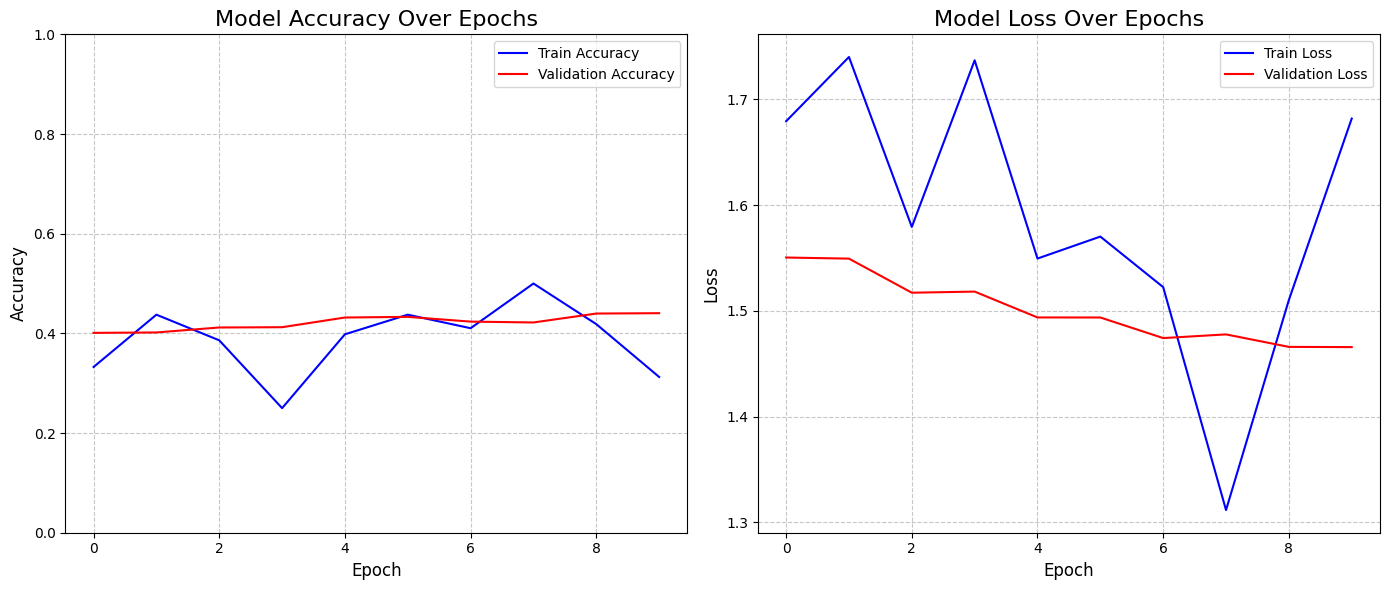

Training history plots saved as 'training_history_plots.png'


In [11]:
# --- 10. Visualize Training History (Loss and Accuracy) ---
print("\nGenerating training history plots...")

plt.figure(figsize=(14, 6)) # Larger figure for better readability

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1) # Ensure accuracy is between 0 and 1

# Plot Training & Validation Loss
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss Over Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() # Adjust layout to prevent overlapping
plot_save_path = 'training_history_plots.png'
plt.savefig(plot_save_path, dpi=300) # Save with higher DPI for better quality
plt.show() # Display the plot
print(f"Training history plots saved as '{plot_save_path}'")



In [12]:
# --- 11. Function for Preprocessing and Prediction ---
def preprocess_and_predict_single_image(model_to_use, image_path, target_size, class_names_list):
    """
    Loads an image, preprocesses it, and makes a prediction using the loaded model.
    """
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return

    try:
        img = tf.keras.utils.load_img(image_path, target_size=target_size)
        img_array = tf.keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
        img_array /= 255.0 # Rescale pixels to [0, 1]

        predictions = model_to_use.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        predicted_class_index = np.argmax(score)
        predicted_class_name = class_names_list[predicted_class_index]
        confidence = 100 * np.max(score)

        print(f"Image: {os.path.basename(image_path)}")
        print(f"Prediction: {predicted_class_name} ({confidence:.2f}%)")
        print(f"All probabilities: {dict(zip(class_names_list, [f'{s*100:.2f}%' for s in score]))}")

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")



In [13]:
# --- 12. Load and Test the Saved Model ---
print("\n--- Testing with saved model ---")
try:
    loaded_model = load_model(model_save_path)
    print(f"Model '{model_save_path}' successfully loaded.")
except Exception as e:
    print(f"Failed to load model: {e}")
    print("Please ensure you have trained and saved the model as 'face_expression_model.h5'.")
    exit()

# Sample image paths (update these to your actual image paths)
sample_image_path_1 = '/kaggle/input/hmmmsz/21.jpeg'
sample_image_path_2 = '/kaggle/input/hmmmsz/goyounjung.jpeg'
sample_image_path_3 = '/kaggle/input/hmmmsz/p.jpeg'

print("\n--- Predicting on Sample Image 1 ---")
preprocess_and_predict_single_image(loaded_model, sample_image_path_1, (IMG_HEIGHT, IMG_WIDTH), class_names)

print("\n--- Predicting on Sample Image 2 ---")
preprocess_and_predict_single_image(loaded_model, sample_image_path_2, (IMG_HEIGHT, IMG_WIDTH), class_names)

print("\n--- Predicting on Sample Image 3 ---")
preprocess_and_predict_single_image(loaded_model, sample_image_path_3, (IMG_HEIGHT, IMG_WIDTH), class_names)

print("\n--- Attempting to predict on a non-existent image ---")
preprocess_and_predict_single_image(loaded_model, 'non_existent_image.jpg', (IMG_HEIGHT, IMG_WIDTH), class_names)


--- Testing with saved model ---
Model 'face_expression_model.h5' successfully loaded.

--- Predicting on Sample Image 1 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Image: 21.jpeg
Prediction: angry (16.59%)
All probabilities: {'angry': '16.59%', 'disgust': '12.46%', 'fear': '14.59%', 'happy': '12.91%', 'neutral': '14.46%', 'sad': '14.62%', 'surprise': '14.38%'}

--- Predicting on Sample Image 2 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Image: goyounjung.jpeg
Prediction: happy (18.82%)
All probabilities: {'angry': '14.00%', 'disgust': '12.54%', 'fear': '14.74%', 'happy': '18.82%', 'neutral': '13.23%', 'sad': '13.32%', 'surprise': '13.35%'}

--- Predicting on Sample Image 3 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Image: p.jpeg
Prediction: sad (19.39%)
All probabilities: {'angry': '14.38%', 'disgust': '12.29%', 'fear': '12.62%', 'happy': '12.86%', 'neutral': '16.18%', 'sad': '19.39%', 'surprise': '12.28%'}

--- Attempting to predict on a non-existent image ---
Error: Image not found at non